# Τρίτη Εργασία

**Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

Νίκος Κιοσσές

ΑΕΜ: 4203

01/2024

### Εισαγωγή Βιβλιοθηκών

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from scipy.spatial.distance import cdist

###Κατέβασμα, προετοιμασία και εμφάνιση δεδομένων


**Κατέβασμα δεδομένων**

In [2]:
# Φόρτωση δεδομένων MNIST
(x_train_original, y_train_original), (x_test_original, y_test_original) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train = x_train_original
y_train = y_train_original
x_test = x_test_original
y_test = y_test_original

**Εμφάνιση δεδομένων**

In [4]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [5]:
print(x_train[0])
print("-------------------------------------------------------")
print(y_train[0])
print("-------------------------------------------------------")
print(y_train)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

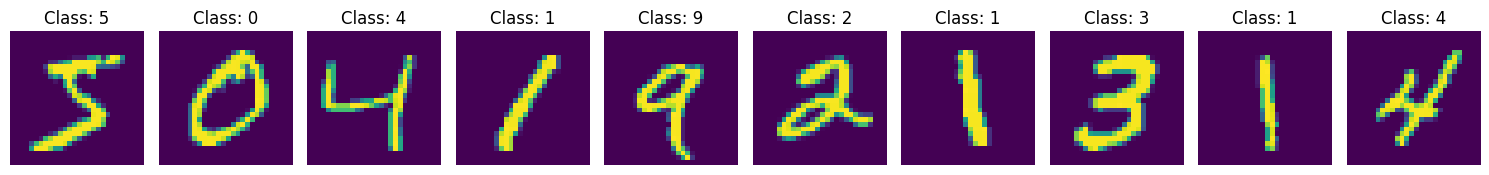

In [6]:
# Εμφάνιση των πρώτων 10 πρώτων εικόνων του x_train_original
num_images = 10

plt.figure(figsize=(15, 5))
for i in range(num_images):
    image = x_train_original[i].reshape(28, 28)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {y_train_original[i]}")
    plt.axis('off')
plt.tight_layout()

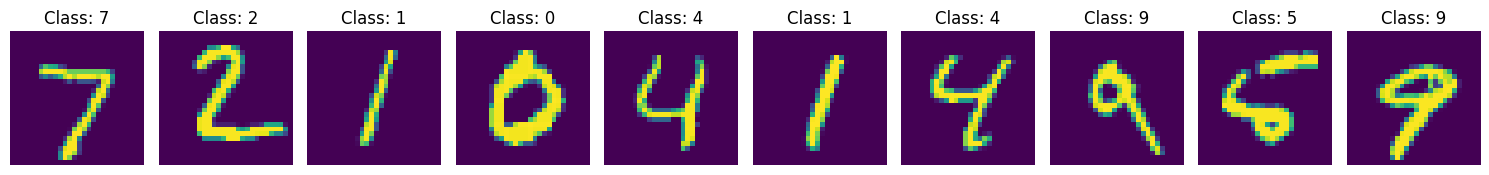

In [7]:
# Εμφάνιση των πρώτων 10 πρώτων εικόνων του x_test_original
num_images = 10

plt.figure(figsize=(15, 5))
for i in range(num_images):
    image = x_test_original[i].reshape(28, 28)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {y_test_original[i]}")
    plt.axis('off')
plt.tight_layout()

**Κανονικοποίηση δεδομένων**

In [8]:
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


**One-hot encoding των ετικετών**

In [9]:
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

## Νευρωνικό Δίκτυο RBF για image generation του επόμενου ψηφίου

### Δημιουργία δικτύου

In [10]:
# Activation Function: Gaussian RBF
def activation(X, c, r):
    """Compute RBF activations."""
    return np.exp(-cdist(X, c, 'sqeuclidean') / (2 * r ** 2))

In [11]:
class RBFN:
    def __init__(self, n_centers, r):
        self.n_centers = n_centers
        self.r = r
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        """Train the RBF network."""
        # Step 1: KMeans to find centers
        kmeans = KMeans(n_clusters=self.n_centers, random_state=0)
        self.centers = kmeans.fit(X).cluster_centers_

        # Step 2: Compute RBF activations
        R = activation(X, self.centers, self.r)

        # Step 3: Solve weights using least squares
        self.weights = np.linalg.pinv(R).dot(y)

    def predict(self, X):
        """Predict output for inputs X."""
        R = activation(X, self.centers, self.r)
        y = R.dot(self.weights)
        return y

In [12]:
n_centers = 100
r = 1.0
rbfn = RBFN(n_centers=n_centers, r=r)

### Image generation

In [14]:
start_time = time.time()

# Εύρεση επόμενου ψηφίου για κάθε δείγμα του y_train
next_digit_train = (y_train + 1) % 10

# Mapping κάθε εικόνας του x_train στο ψηφίο που αντιστοιχεί
image_map = {i: [] for i in range(10)}
for i in range(len(y_train)):
    image_map[y_train[i]].append(x_train[i])

# Generate target images for the next digit
next_digit_images = []
for i in range(len(y_train)):
  # Επόμενο ψηφίο για την εικόνα
  target_digit = next_digit_train[i]
  # Εικόνες του x_train που αναφέρονται στο target_digit
  target_images = image_map[target_digit]
  # Εύρεση της μέσης εικόνας του target digit
  next_digit_images.append(np.median(target_images, axis=0))

# Μετατροπή σε np.array
next_digit_images2 = np.array(next_digit_images)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Training time: 5086.197503089905 seconds


In [17]:
print(np.array(next_digit_images).shape)

(60000, 784)


In [18]:
# Δημιουργία εικόνας επόμενου ψηφίου μιας εικόνας με βάση το Νευρωνικό Δίκτυο
def generate_next_digit(image, rbfn):
    """Generate the next digit image based on the current image."""
    next_digit_image = rbfn.predict(image.reshape(1, -1)).reshape(28, 28)
    return next_digit_image

### Εκπαίδευση δικτύου

In [15]:
start_time = time.time()

rbfn.fit(x_train, next_digit_images2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Training time: 71.80237245559692 seconds


### Παράδειγμα generation

In [19]:
# Δημιουργία για τις 10 πρώτες εικόνες του x_test
generated_images = []
for i in range(10):
    generated_image = generate_next_digit(x_test[i], rbfn)
    generated_images.append(generated_image)

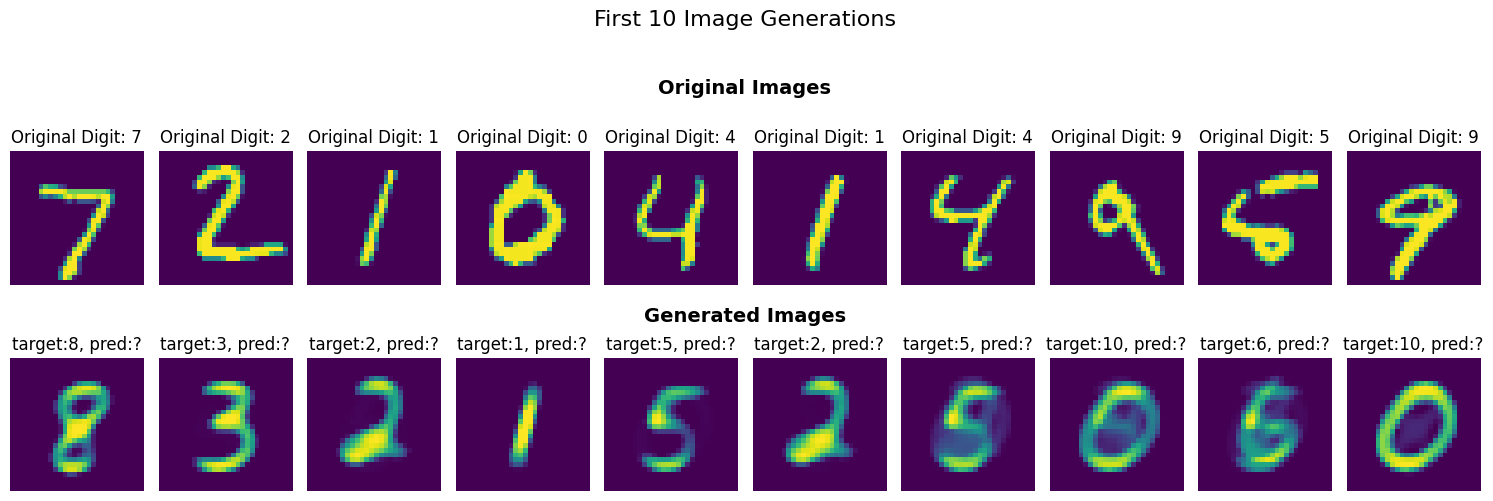

In [20]:
# Εμφάνιση των αποτελεσμάτων
fig, axes = plt.subplots(2, 10, figsize=(15, 6))

for i in range(10):
    # Αρχική εικόνα
    axes[0, i].imshow(x_test[i].reshape(28, 28))
    axes[0, i].set_title(f"Original Digit: {y_test[i]}")
    axes[0, i].axis('off')

    # Γεννημένη εικόνα
    axes[1, i].imshow(generated_images[i])
    axes[1, i].set_title(f"target:{y_test[i]+1}, pred:?")
    axes[1, i].axis('off')

# Προσθήκη τίτλων σε κάθε γραμμή
fig.text(0.5, 0.85, "Original Images", ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.47, "Generated Images", ha='center', va='center', fontsize=14, fontweight='bold')

plt.suptitle("First 10 Image Generations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
plt.show()

## Νευρωνικό Δίκτυο RBF για αναγνώριση ψηφίων

### Δημιουργία δικτύου

In [21]:
# Activation Function: Gaussian RBF
def activation(X, c, r):
    """Compute RBF activations."""
    return np.exp(-cdist(X, c, 'sqeuclidean') / (2 * r ** 2))

In [22]:
class RBFNClassification:
    def __init__(self, n_centers, r):
        self.n_centers = n_centers
        self.r = r
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        """Train the RBF network."""
        # Step 1: KMeans to find centers
        kmeans = KMeans(n_clusters=self.n_centers, random_state=0)
        self.centers = kmeans.fit(X).cluster_centers_

        # Step 2: Compute RBF activations
        R = activation(X, self.centers, self.r)

        # Step 3: Solve weights using least squares
        self.weights = np.linalg.pinv(R).dot(y)

    def predict(self, X):
        """Predict output for inputs X."""
        R = activation(X, self.centers, self.r)
        y = R.dot(self.weights)
        return y

In [23]:
n_centers = 200
r = 1.0
rbfnClassification = RBFNClassification(n_centers=n_centers, r=r)

### Εκπαίδευση δικτύου

In [24]:
start_time = time.time()

rbfnClassification.fit(x_train, y_train_onehot)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Training time: 110.77709865570068 seconds


### Αξιολόγηση δικτύου

**Αξιολόγηση στα δεδομένα του test set.**

In [25]:
y_pred = rbfnClassification.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 89.81%


In [26]:
print(y_pred)
print(y_test)

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


In [27]:
print("y_pred:", end=" ")
for label in y_pred:
    print(label, end=" ")
print()
print("y_test:", end=" ")
for label in y_test:
    print(label, end=" ")
print()

y_pred: 7 2 1 0 4 1 4 9 9 9 0 6 9 0 1 3 9 7 3 4 9 6 6 5 1 0 7 4 0 1 3 1 3 1 7 2 7 1 3 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 2 7 1 6 4 3 0 7 0 2 7 1 7 3 2 9 7 9 6 2 7 5 4 7 3 6 1 3 6 4 3 1 4 1 3 6 9 6 0 5 4 9 9 2 1 9 4 8 7 3 9 7 9 9 4 9 2 8 4 7 6 7 9 0 5 8 5 6 6 5 2 8 1 0 1 6 4 6 7 3 1 7 1 8 2 0 1 9 5 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 9 9 7 2 3 2 1 1 8 1 8 1 8 5 0 8 9 2 5 0 1 1 1 0 3 0 1 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0 3 5 5 5 7 2 2 7 1 2 8 1 1 7 3 3 8 8 7 9 2 2 4 1 5 8 8 7 2 1 0 2 4 2 9 1 9 5 7 7 2 8 2 6 8 5 7 7 9 1 8 1 8 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4 1 5 5 2 9 2 0 4 0 0 2 8 2 7 1 1 9 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5 7 7 9 3 5 4 2 0 7 1 1 2 1 5 3 8 9 7 5 6 3 1 1 3 8 1 0 5 1 3 1 5 3 6 1 8 5 1 9 9 4 6 2 2 5 0 6 5 6 3 7 2 0 8 8 5 9 1 1 4 0 1 3 7 6 1 6 2 1 9 2 8 6 1 9 5 2 5 4 9 2 8 3 5 2 4 5 0 3 1 7 7 5 7 9 7 1 9 2 1 1 2 9 2 0 4 9 1 4 8 1 5 9 5 9 8 8 3 7 6 0 0 3 1 8 0 6 4 8 3 3 3 2 3 9 1 2 6 8 0 5 6 6 6 7 8 8 2 7 5 8 9 6 1 8 4 1 2 3 5 1 9 7 1 4 0 8 9 9 1 0 5 2 3 7 8 

**Εμφάνιση παραδειγμάτων σωστής και λανθασμένης πρόβλεψης**

In [28]:
correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

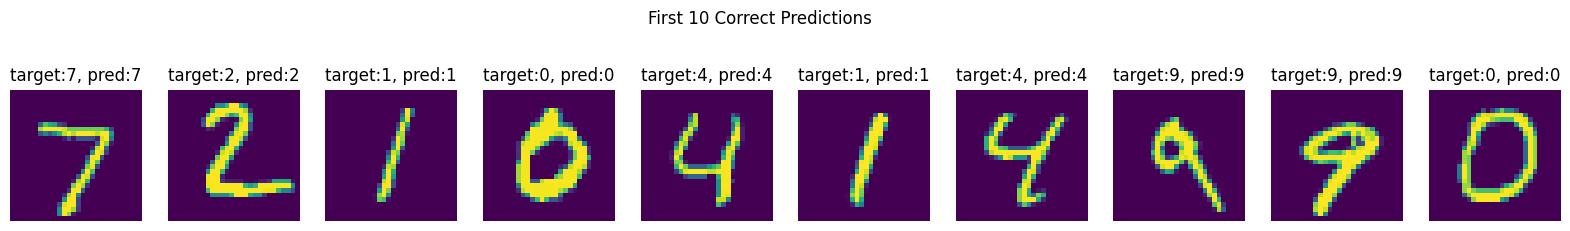

In [29]:
# Εμφάνιση πρώτων 10 σωστών προβλέψεων
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, idx in enumerate(correct_indices[:10]):
    image = x_test[idx].reshape(28, 28)
    axes[i].imshow(image)
    axes[i].set_title(f"target:{y_test[idx]}, pred:{y_pred[idx]}")
    axes[i].axis("off")
plt.suptitle("First 10 Correct Predictions")
plt.show()

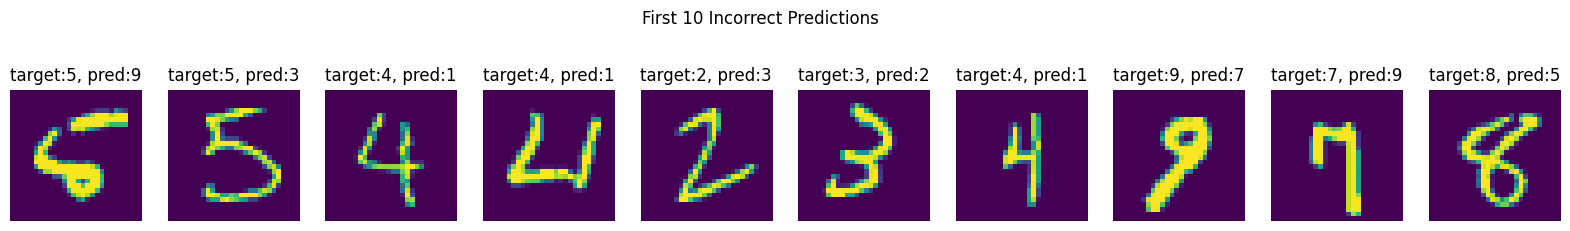

In [30]:
# Εμφάνιση πρώτων 10 λανθασμένων προβλέψεων
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, idx in enumerate(incorrect_indices[:10]):
    image = x_test[idx].reshape(28, 28)
    axes[i].imshow(image)
    axes[i].set_title(f"target:{y_test[idx]}, pred:{y_pred[idx]}")
    axes[i].axis("off")
plt.suptitle("First 10 Incorrect Predictions")
plt.show()

**Αξιολόγηση στα δεδομένα του train set.**

In [31]:
y_pred = rbfnClassification.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred == y_train)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 89.23%


In [32]:
print(y_pred)
print(y_train)

[5 0 1 ... 5 6 8]
[5 0 4 ... 5 6 8]


## Έλεγχος αναγνώρισης δημιουργημένων εικόνων (Αξιολόγηση απόδοσης δημιουργίας)

### Δοκιμή σε μία εικόνα με και χωρίς αύξηση αντίθεσης της generated εικόνας

In [33]:
# Εύρεση του επόμενου ψηφίου της πρώτης εικόνας του x_test
next_digit = (y_test[0] + 1) % 10

print(next_digit)

8


In [34]:
# Δημιουργία νέας εικόνας για το επόμενο ψηφίο
generated_image = generate_next_digit(x_test[0], rbfn)

In [35]:
# Αναπροσαρμογή τιμών εικόνας για καλύτερη αντίθεση
def enhance_contrast(image):
    # Κανονικοποίηση μεταξύ 0-1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    # Ενίσχυση αντίθεσης κατά 1.5
    image = np.clip(image * 1.5, 0, 1)
    return image

enhanced_image = np.array(enhance_contrast(generated_image.reshape(-1, 28*28)))

In [36]:
print(generated_image.shape)
print(enhanced_image.shape)

(28, 28)
(1, 784)


In [37]:
generated_image = generated_image.reshape(-1, 28*28)
enhanced_image = enhanced_image.reshape(-1, 28*28)

print(generated_image.shape)
print(enhanced_image.shape)

(1, 784)
(1, 784)


In [38]:
# Ταξινόμηση της δημιουργημένης εικόνας με το rbfnClassification
y_pred_gen = rbfnClassification.predict(generated_image.reshape(-1, 28*28))
y_pred_gen = int(np.argmax(y_pred_gen, axis=1))
# Ταξινόμηση της δημιουργημένης εικόνας με αυξημένη αντίθεση με το rbfnClassification
y_pred_enh = rbfnClassification.predict(enhanced_image)
y_pred_enh = int(np.argmax(y_pred_enh, axis=1))

<ipython-input-38-69d3e2689c60>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_gen = int(np.argmax(y_pred_gen, axis=1))
<ipython-input-38-69d3e2689c60>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_enh = int(np.argmax(y_pred_enh, axis=1))


(-0.5, 27.5, 27.5, -0.5)

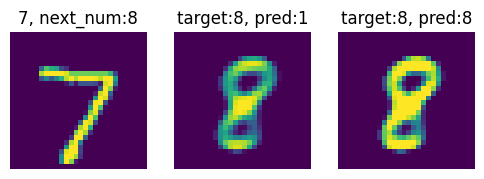

In [39]:
# Εμφάνιση της εικόνας του x_test, της δημιουργημένης εικόνας και της δημιουργημένης εικόνας με αυξημένη αντίθεση
# Εκτύπωση των προβλέψεων της ταξινόμηση από το νευρωνικό αναγνώρισης ψηφίων
fig, axes = plt.subplots(1, 3, figsize=(6, 6))

axes[0].imshow(x_test[0].reshape(28, 28))
axes[0].set_title(f"{y_test[0]}, next_num:{next_digit}")
axes[0].axis("off")

axes[1].imshow(generated_image.reshape(28, 28))
axes[1].set_title(f"target:{next_digit}, pred:{y_pred_gen}")
axes[1].axis("off")

axes[2].imshow(enhanced_image.reshape(28, 28))
axes[2].set_title(f"target:{next_digit}, pred:{y_pred_enh}")
axes[2].axis("off")

### Δοκιμή σε όλες τις εικόνες του x_test με και χωρίς αύξηση αντίθεσης της generated εικόνας

**Δημιουργία και επεξεργασία**

In [47]:
# Εύρεση του επόμενου ψηφίου κάθε εικόνας του x_test
next_digit_test = (y_test + 1) % 10
print(next_digit_test)

[8 3 2 ... 5 6 7]


In [48]:
# Δημιουργία εικόνας επόμενου ψηφίου για κάθε εικόνα του test set
generated_images = []
for i in range(len(x_test)):
    generated_image = generate_next_digit(x_test[i], rbfn)
    generated_images.append(generated_image)
generated_images = np.array(generated_images)

In [49]:
# Αναπροσαρμογή τιμών εικόνας για καλύτερη αντίθεση
def enhance_contrast(image):
    # Κανονικοποίηση μεταξύ 0-1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    # Ενίσχυση αντίθεσης κατά 1.5
    image = np.clip(image * 1.5, 0, 1)
    return image

# Εφαρμογή σε όλες τις παραγόμενες εικόνες
enhanced_images = []
for img in generated_images:
  enhanced_images.append(enhance_contrast(img.reshape(28, 28)))
enhanced_images = np.array(enhanced_images)

In [50]:
print(generated_images.shape)
print(enhanced_images.shape)

(10000, 28, 28)
(10000, 28, 28)


In [51]:
# Κανονικοποίηση δημιουργημένων εικόνων
generated_images = generated_images.reshape(-1, 28 * 28)
enhanced_images = enhanced_images.reshape(-1, 28 * 28)

print(generated_images.shape)
print(enhanced_images.shape)

(10000, 784)
(10000, 784)


**Έλεγχος δημιουργημένων εικόνων**

In [53]:
# Ταξινόμηση δημιουργημένων εικόνων με το rbfnClassification
y_pred_gen = rbfnClassification.predict(generated_images)
y_pred_gen = np.argmax(y_pred_gen, axis=1)
accuracy = np.mean(y_pred_gen == next_digit_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 14.65%


In [54]:
print("y_pred_gen:     ", end=" ")
for label in y_pred_gen:
    print(label, end=" ")
print()
print("next_digit_test:", end=" ")
for label in next_digit_test:
    print(label, end=" ")
print()

y_pred_gen:      1 1 1 1 1 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1

In [55]:
# Εύρεση σωστών και λανθασμένων προβλέψεων
correct_indices_gen = np.where(y_pred_gen == next_digit_test)[0]
incorrect_indices_gen = np.where(y_pred_gen != next_digit_test)[0]

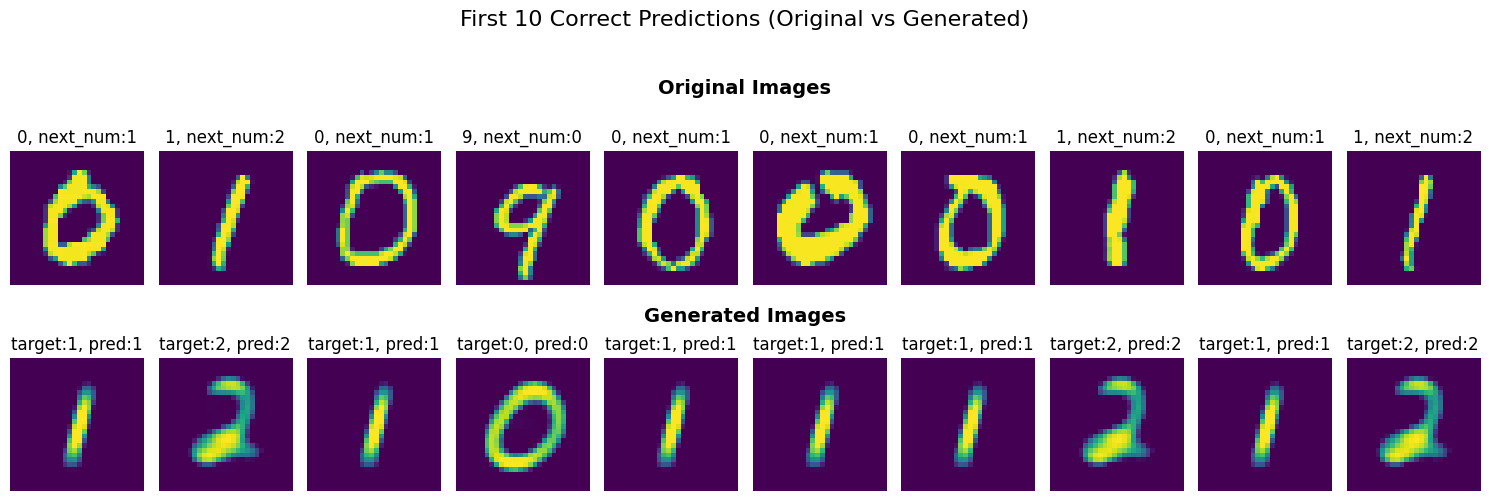

In [56]:
# Εμφάνιση πρώτων 10 σωστών προβλέψεων
fig, axes = plt.subplots(2, 10, figsize=(15, 6))

# Εμφάνιση των πρωτότυπων εικόνων
for i, idx in enumerate(correct_indices_gen[:10]):
    original_image = x_test[idx].reshape(28, 28)
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"{y_test[idx]}, next_num:{next_digit_test[idx]}")
    axes[0, i].axis("off")

# Εμφάνιση των δημιουργημένων εικόνων
for i, idx in enumerate(correct_indices_gen[:10]):
    image = generated_images[idx].reshape(28, 28)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f"target:{next_digit_test[idx]}, pred:{y_pred_gen[idx]}")
    axes[1, i].axis("off")

# Προσθήκη τίτλων σε κάθε γραμμή
fig.text(0.5, 0.85, "Original Images", ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.47, "Generated Images", ha='center', va='center', fontsize=14, fontweight='bold')

plt.suptitle("First 10 Correct Predictions (Original vs Generated)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
plt.show()

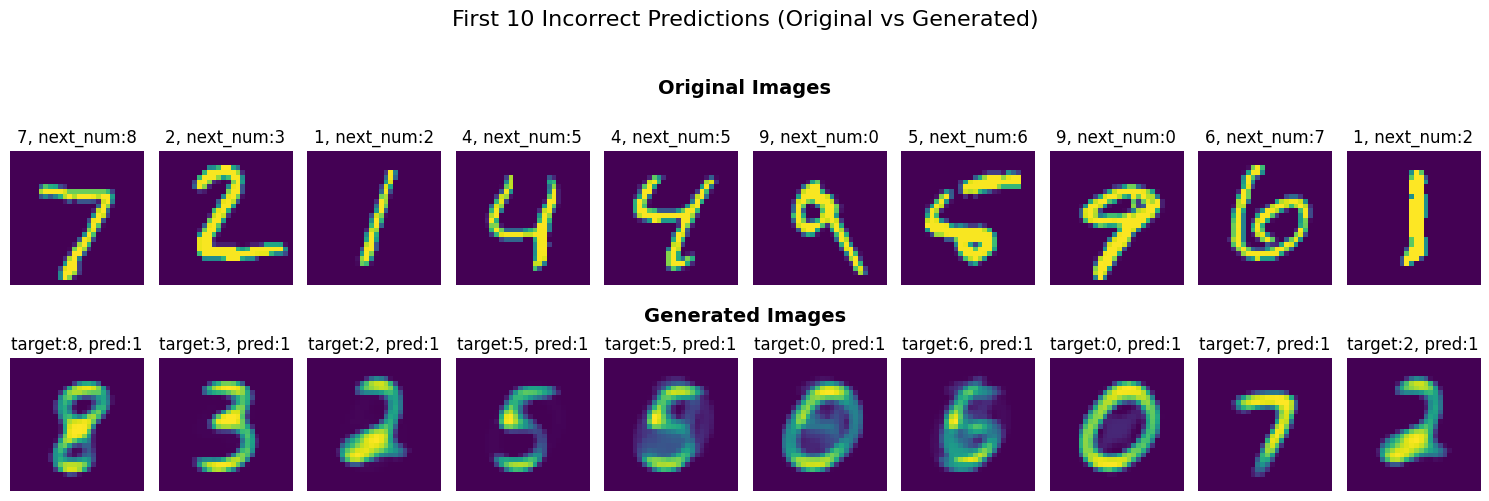

In [57]:
# Εμφάνιση πρώτων 10 λανθασμένων προβλέψεων
fig, axes = plt.subplots(2, 10, figsize=(15, 6))

# Εμφάνιση των πρωτότυπων εικόνων
for i, idx in enumerate(incorrect_indices_gen[:10]):
    original_image = x_test[idx].reshape(28, 28)
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"{y_test[idx]}, next_num:{next_digit_test[idx]}")
    axes[0, i].axis("off")

# Εμφάνιση των δημιουργημένων εικόνων
for i, idx in enumerate(incorrect_indices_gen[:10]):
    image =  generated_images[idx].reshape(28, 28)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f"target:{next_digit_test[idx]}, pred:{y_pred_gen[idx]}")
    axes[1, i].axis("off")

# Προσθήκη τίτλων σε κάθε γραμμή
fig.text(0.5, 0.85, "Original Images", ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.47, "Generated Images", ha='center', va='center', fontsize=14, fontweight='bold')

plt.suptitle("First 10 Incorrect Predictions (Original vs Generated)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
plt.show()

**Έλεγχος δημιουργημένων εικόνων με αυξημένη αντίθεση**

In [59]:
# Ταξινόμηση δημιουργημένων εικόνων με αυξημένη αντίθεση με το rbfnClassification
y_pred_enh = rbfnClassification.predict(enhanced_images)
y_pred_enh = np.argmax(y_pred_enh, axis=1)
accuracy = np.mean(y_pred_enh == next_digit_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 84.82%


In [60]:
print("y_pred_enh:     ", end=" ")
for label in y_pred_enh:
    print(label, end=" ")
print()
print("next_digit_test:", end=" ")
for label in next_digit_test:
    print(label, end=" ")
print()

y_pred_enh:      8 3 2 1 5 2 5 0 6 0 1 7 0 1 2 6 0 8 6 5 0 7 7 6 2 1 8 5 1 2 4 2 4 7 8 3 8 2 3 2 2 8 5 2 4 6 2 8 5 0 7 6 6 6 7 1 5 2 0 2 8 3 2 4 8 0 7 5 4 1 8 1 3 8 2 8 4 2 0 8 0 7 3 8 9 5 8 4 7 2 4 7 8 4 2 5 2 3 7 0 7 1 6 0 5 0 3 2 0 5 9 8 4 0 3 0 0 5 0 3 6 5 8 7 8 0 1 6 9 6 7 7 6 8 9 2 1 2 7 5 7 8 4 2 8 2 9 3 1 2 0 6 6 6 2 6 7 1 4 8 5 7 6 5 7 6 0 6 2 0 0 8 3 4 3 2 2 9 2 9 2 9 6 1 9 0 3 6 1 2 2 2 1 9 1 2 2 7 0 3 4 7 2 2 2 4 0 6 3 0 5 6 0 4 0 1 4 7 6 6 8 3 3 8 2 3 9 2 2 8 4 4 9 9 8 0 3 3 5 2 6 6 9 8 3 2 1 3 5 3 0 2 0 6 8 8 3 9 3 1 9 6 8 8 9 2 4 2 6 1 4 1 2 0 0 0 2 9 3 2 3 0 8 6 0 3 7 5 2 6 9 3 0 3 1 0 1 1 3 9 2 3 2 2 0 1 3 8 5 4 4 1 1 4 2 0 7 6 3 6 8 8 0 4 6 8 3 1 8 2 2 3 2 6 4 9 0 8 6 7 6 2 2 4 9 2 1 6 2 9 2 6 6 7 2 9 6 2 2 0 5 7 4 3 6 1 3 6 7 4 8 3 1 9 9 6 0 2 2 5 1 2 4 8 7 2 7 3 2 0 3 9 7 2 2 6 3 6 0 5 3 9 4 6 3 5 9 1 4 2 8 8 9 8 0 8 2 0 3 2 2 3 0 3 1 5 8 2 5 9 2 2 2 6 0 9 9 6 8 7 1 1 4 2 9 1 7 5 9 6 6 4 3 6 0 2 8 7 9 1 6 7 7 7 8 9 9 3 8 6 9 0 7 2 9 5 2 3 2 6 2 0 8 2 0 1 9 0 8 2 1 6

In [61]:
# Εύρεση σωστών και λανθασμένων προβλέψεων
correct_indices_enh = np.where(y_pred_enh == next_digit_test)[0]
incorrect_indices_enh = np.where(y_pred_enh != next_digit_test)[0]

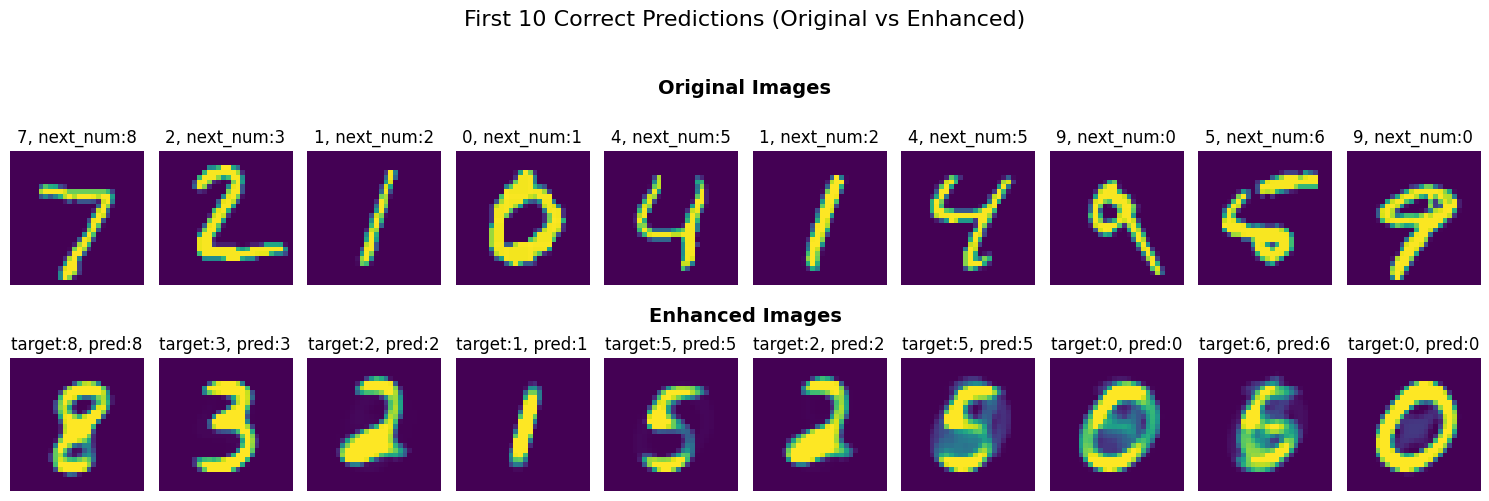

In [62]:
# Εμφάνιση πρώτων 10 σωστών προβλέψεων
fig, axes = plt.subplots(2, 10, figsize=(15, 6))

# Εμφάνιση των πρωτότυπων εικόνων
for i, idx in enumerate(correct_indices_enh[:10]):
    original_image = x_test[idx].reshape(28, 28)
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"{y_test[idx]}, next_num:{next_digit_test[idx]}")
    axes[0, i].axis("off")

# Εμφάνιση των δημιουργημένων εικόνων με αυξημένη αντίθεση
for i, idx in enumerate(correct_indices_enh[:10]):
    image = enhanced_images[idx].reshape(28, 28)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f"target:{next_digit_test[idx]}, pred:{y_pred_enh[idx]}")
    axes[1, i].axis("off")

# Προσθήκη τίτλων σε κάθε γραμμή
fig.text(0.5, 0.85, "Original Images", ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.47, "Enhanced Images", ha='center', va='center', fontsize=14, fontweight='bold')

plt.suptitle("First 10 Correct Predictions (Original vs Enhanced)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
plt.show()

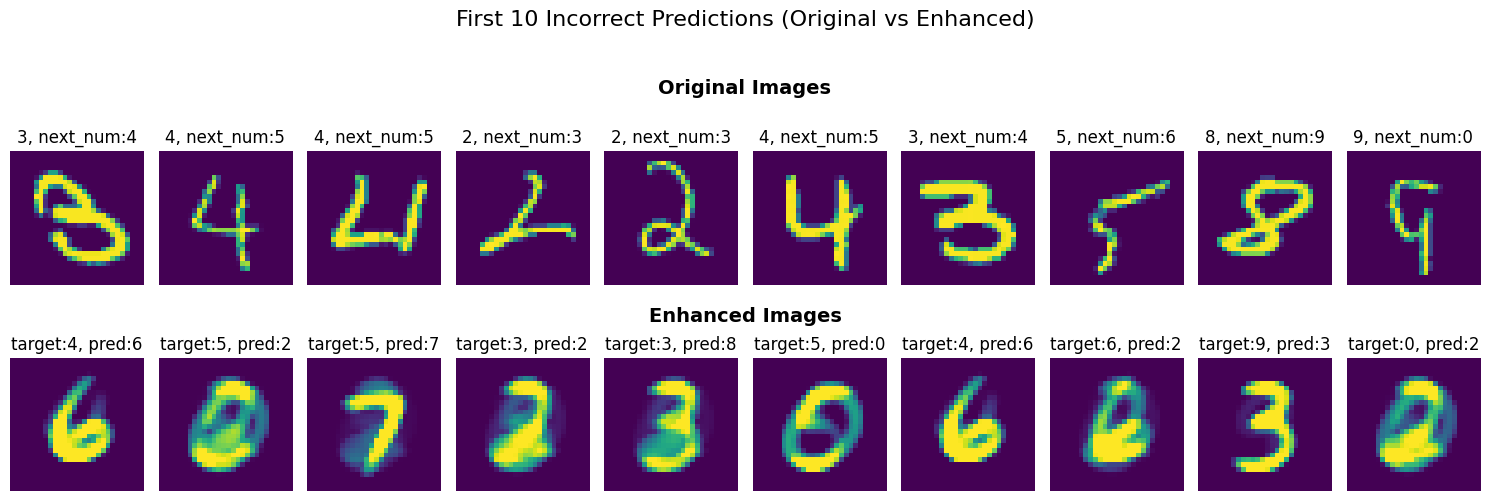

In [63]:
# Εμφάνιση πρώτων 10 λανθασμένων προβλέψεων
fig, axes = plt.subplots(2, 10, figsize=(15, 6))

# Εμφάνιση των πρωτότυπων εικόνων
for i, idx in enumerate(incorrect_indices_enh[:10]):
    original_image = x_test[idx].reshape(28, 28)
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"{y_test[idx]}, next_num:{next_digit_test[idx]}")
    axes[0, i].axis("off")

# Εμφάνιση των δημιουργημένων εικόνων με αυξημένη αντίθεση
for i, idx in enumerate(incorrect_indices_enh[:10]):
    image = enhanced_images[idx].reshape(28, 28)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f"target:{next_digit_test[idx]}, pred:{y_pred_enh[idx]}")
    axes[1, i].axis("off")

# Προσθήκη τίτλων σε κάθε γραμμή
fig.text(0.5, 0.85, "Original Images", ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.47, "Enhanced Images", ha='center', va='center', fontsize=14, fontweight='bold')

plt.suptitle("First 10 Incorrect Predictions (Original vs Enhanced)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
plt.show()